# Задание по программированию: Дифференциально экспрессированные гены

In [1]:
import numpy as np
import pandas as pd

from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Данные для этой задачи взяты из исследования, проведенного в Stanford School of Medicine. В исследовании была предпринята попытка выявить набор  генов, которые позволили  бы более точно диагностировать возникновение рака груди на самых ранних стадиях.

В эксперименте принимали участие 24 человек, у которых не было рака груди (normal), 25 человек, у которых это заболевание было диагностировано на ранней стадии (early neoplasia), и 23 человека с сильно выраженными симптомами (cancer).

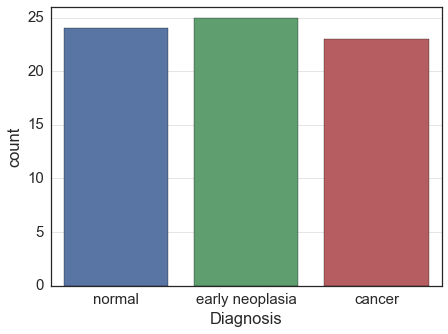

Ученые провели секвенирование биологического материала испытуемых, чтобы понять, какие из этих генов наиболее активны в клетках больных людей. 

Секвенирование — это определение степени активности генов в анализируемом образце с помощью подсчёта количества соответствующей каждому гену РНК.

В данных для этого задания вы найдете именно эту количественную меру активности каждого из 15748 генов у каждого из 72 человек, принимавших участие в эксперименте.

Вам нужно будет определить те гены, активность которых у людей в разных стадиях заболевания отличается статистически значимо.

Кроме того, вам нужно будет оценить не только статистическую, но и практическую значимость этих результатов, которая часто используется в подобных исследованиях.

Диагноз человека содержится в столбце под названием "Diagnosis". 

Практическая значимость изменения

Цель исследований — найти гены, средняя экспрессия которых отличается не только статистически значимо, но и достаточно сильно. В экспрессионных исследованиях для этого часто используется метрика, которая называется fold change (кратность изменения). Определяется она следующим образом:

$$F_C (C,T) = \frac{T}{C}, T>C \; или \; \frac{C}{T}, C>T $$

где C,T — средние значения экспрессии гена в control и treatment группах соответственно. По сути, fold change показывает, во сколько раз отличаются средние двух выборок.

In [4]:
data = pd.read_csv('gene.csv', delimiter = ',', header = 0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Columns: 15750 entries, Patient_id to EIF1AY
dtypes: float64(15748), object(2)
memory usage: 8.7+ MB


In [5]:
data.shape

(72, 15750)

In [6]:
data.head()

,Patient_id,Diagnosis,LOC643837,LOC100130417,SAMD11,NOC2L,KLHL17,PLEKHN1,C1orf170,HES4,...,CLIC2,RPS4Y1,ZFY,PRKY,USP9Y,DDX3Y,CD24,CYorf15B,KDM5D,EIF1AY
0,STT5425_Breast_001_normal,normal,1.257614,2.408148,13.368622,9.494779,20.880435,12.722017,9.494779,54.349694,...,4.761250,1.257614,1.257614,1.257614,1.257614,1.257614,23.268694,1.257614,1.257614,1.257614
1,STT5427_Breast_023_normal,normal,4.567931,16.602734,42.477752,25.562376,23.221137,11.622386,14.330573,72.445474,...,6.871902,1.815112,1.815112,1.815112,1.815112,1.815112,10.427023,1.815112,1.815112,1.815112
2,STT5430_Breast_002_normal,normal,2.077597,3.978294,12.863214,13.728915,14.543176,14.141907,6.232790,57.011005,...,7.096343,2.077597,2.077597,2.077597,2.077597,2.077597,22.344226,2.077597,2.077597,2.077597
3,STT5439_Breast_003_normal,normal,2.066576,8.520713,14.466035,7.823932,8.520713,2.066576,10.870009,53.292034,...,5.200770,2.066576,2.066576,2.066576,2.066576,2.066576,49.295538,2.066576,2.066576,2.066576
4,STT5441_Breast_004_normal,normal,2.613616,3.434965,12.682222,10.543189,26.688686,12.484822,1.364917,67.140393,...,11.227770,1.364917,1.364917,1.364917,1.364917,1.364917,23.627911,1.364917,1.364917,1.364917


In [7]:
data.dropna().shape

(72, 15750)

## Часть 1: применение t-критерия Стьюдента

В первой части вам нужно будет применить критерий Стьюдента для проверки гипотезы о равенстве средних в двух независимых выборках. Применить критерий для каждого гена нужно будет дважды:

    для групп normal (control) и early neoplasia (treatment)
    для групп early neoplasia (control) и cancer (treatment)

В качестве ответа в этой части задания необходимо указать количество статистически значимых отличий, которые вы нашли с помощью t-критерия Стьюдента, то есть число генов, у которых p-value этого теста оказался меньше, чем уровень значимости

In [10]:
norm = data[data.Diagnosis == 'normal']
early = data[data.Diagnosis == 'early neoplasia']
cancer = data[data.Diagnosis == 'cancer']
print(norm.shape, early.shape, cancer.shape)

(24, 15750) (25, 15750) (23, 15750)


In [26]:
features = data.columns.drop(['Patient_id', 'Diagnosis'])
features

Index(['LOC643837', 'LOC100130417', 'SAMD11', 'NOC2L', 'KLHL17', 'PLEKHN1',
       'C1orf170', 'HES4', 'ISG15', 'AGRN',
       ...
       'CLIC2', 'RPS4Y1', 'ZFY', 'PRKY', 'USP9Y', 'DDX3Y', 'CD24', 'CYorf15B',
       'KDM5D', 'EIF1AY'],
      dtype='object', length=15748)

In [48]:
norm_early_p_values = []
early_cancer_p_values = []
for feature in features:
    norm_early_p_values.append(stats.ttest_ind(norm[feature], early[feature], equal_var = False)[1])
    early_cancer_p_values.append(stats.ttest_ind(early[feature], cancer[feature], equal_var = False)[1])
norm_early_p_values = np.array(norm_early_p_values)
early_cancer_p_values = np.array(early_cancer_p_values)

Количество статистически значимых отличий normal - early neoplasia:  1575
Количество статистически значимых отличий early neoplasia - cancer:  3490


In [50]:
print('Количество статистически значимых отличий normal - early neoplasia: ', np.sum(norm_early_p_values < 0.05))
print('Количество статистически значимых отличий early neoplasia - cancer: ', np.sum(early_cancer_p_values < 0.05))

Количество статистически значимых отличий normal - early neoplasia:  1575
Количество статистически значимых отличий early neoplasia - cancer:  3490


In [51]:
def write_answer(num, string):
    with open(string, "w") as fout:
        fout.write(str(num))

In [52]:
write_answer(num = np.sum(norm_early_p_values < 0.05), string = 'answer_1.1')
write_answer(num = np.sum(early_cancer_p_values < 0.05), string = 'answer_1.2')

## Часть 2: поправка методом Холма

In [54]:
import statsmodels.stats.multitest as smm

В этой части задания нужно будет применить поправку Холма для получившихся двух наборов достигаемых уровней значимости из предыдущей части. Обратите внимание, что поскольку вы будете делать поправку для каждого из двух наборов p-value отдельно, то проблема, связанная с множественной проверкой останется.

Для того, чтобы ее устранить, достаточно воспользоваться поправкой Бонферрони, то есть использовать уровень значимости 0.05 / 2 вместо 0.05 для дальнейшего уточнения значений p-value c помощью метода Холма.

В качестве ответа к этому заданию требуется ввести количество значимых отличий в каждой группе после того, как произведена коррекция Холма-Бонферрони. Причем это число нужно ввести с учетом практической значимости: посчитайте для каждого значимого изменения fold change и выпишите в ответ число таких значимых изменений, абсолютное значение fold change которых больше, чем 1.5.

Обратите внимание, что

    применять поправку на множественную проверку  нужно  ко всем  значениям достигаемых уровней значимости, а не только для тех, которые меньше значения уровня доверия.  
    при использовании поправки на уровне значимости 0.025 меняются значения достигаемого уровня значимости, но не меняется значение уровня доверия (то есть для отбора значимых изменений скорректированные значения уровня значимости нужно сравнивать с порогом 0.025, а не 0.05)!


In [66]:
reject_1, p_corrected_1, a1_1, a2_1 = smm.multipletests(norm_early_p_values, 
                                            alpha = 0.05/2., 
                                            method = 'holm') 

In [76]:
reject_2, p_corrected_2, a1_2, a2_2 = smm.multipletests(early_cancer_p_values, 
                                            alpha = 0.05/2., 
                                            method = 'holm')

In [93]:
# create DataFrame with all results: p1 - norm vs early mean diff p_value, p2 - early vs cancer
table = pd.DataFrame()
table['norm mean'] = norm.mean()
table['early mean'] = early.mean()
table['cancer mean'] = cancer.mean()
table['p1'] = norm_early_p_values
table['p2'] = early_cancer_p_values
table['p1 corr. Holm'] = p_corrected_1
table['reject1 Holm'] = reject_1
table['p2 corr. Holm'] = p_corrected_2
table['reject2 Holm'] = reject_2
table.head()

,norm mean,early mean,cancer mean,p1,p2,p1 corr.,reject1,p2 corr.,reject2
LOC643837,2.681277,2.510894,2.186060,0.690766,0.413735,1.000000,False,1.0,False
LOC100130417,4.368497,8.721781,8.190456,0.000032,0.653429,0.500174,False,1.0,False
SAMD11,15.159566,18.531325,23.692614,0.060273,0.079556,1.000000,False,1.0,False
NOC2L,15.374351,15.071854,16.468034,0.826429,0.287581,1.000000,False,1.0,False
KLHL17,21.459886,24.152469,25.035813,0.049876,0.463292,1.000000,False,1.0,False


In [106]:
maximum_1 = np.maximum(table['norm mean'], table['early mean'])
minimum_1 = np.minimum(table['norm mean'], table['early mean'])
fold_change_1 = maximum_1 / minimum_1
maximum_2 = np.maximum(table['cancer mean'], table['early mean'])
minimum_2 = np.minimum(table['cancer mean'], table['early mean'])
fold_change_2 = maximum_2 / minimum_2

In [107]:
table['Fold Change norm-early'] = fold_change_1
table['Fold Change early-cancer'] = fold_change_2
table.head()

,norm mean,early mean,cancer mean,p1,p2,p1 corr.,reject1,p2 corr.,reject2,Fold Change norm-early,Fold Change early-cancer
LOC643837,2.681277,2.510894,2.186060,0.690766,0.413735,1.000000,False,1.0,False,1.067858,1.148593
LOC100130417,4.368497,8.721781,8.190456,0.000032,0.653429,0.500174,False,1.0,False,1.996517,1.064871
SAMD11,15.159566,18.531325,23.692614,0.060273,0.079556,1.000000,False,1.0,False,1.222418,1.278517
NOC2L,15.374351,15.071854,16.468034,0.826429,0.287581,1.000000,False,1.0,False,1.020070,1.092635
KLHL17,21.459886,24.152469,25.035813,0.049876,0.463292,1.000000,False,1.0,False,1.125471,1.036574


In [114]:
ans_2_1 = table.loc[(table['Fold Change norm-early'] > 1.5) & (table['p1 corr. Holm'] < 0.025), 'reject1 Holm'].sum() 
ans_2_2 = table.loc[(table['Fold Change early-cancer'] > 1.5) & (table['p2 corr. Holm'] < 0.025), 'reject2 Holm'].sum()

In [116]:
write_answer(num = ans_2_1, string = 'answer_2.1')
write_answer(num = ans_2_2, string = 'answer_2.2')

## Часть 3: поправка методом Бенджамини-Хохберга

Данная часть задания аналогична второй части за исключением того, что нужно будет использовать метод Бенджамини-Хохберга.

 Обратите внимание, что методы коррекции, которые контролируют FDR, допускает больше ошибок первого рода и имеют большую мощность, чем методы, контролирующие FWER. Большая мощность означает, что эти методы будут совершать меньше ошибок второго рода (то есть будут лучше улавливать отклонения от $H_0$, когда они есть, и будут чаще отклонять $H_0$, когда отличий нет).

В качестве ответа к этому заданию требуется  ввести количество значимых отличий в каждой группе после того, как произведена коррекция Бенджамини-Хохберга, причем так же, как и во второй части, считать только такие отличия, у которых abs(fold change) > 1.5. 

In [117]:
reject_3, p_corrected_3, a1_3, a2_3 = smm.multipletests(norm_early_p_values, 
                                            alpha = 0.05/2., 
                                            method = 'fdr_bh')
reject_4, p_corrected_4, a1_4, a2_4 = smm.multipletests(early_cancer_p_values, 
                                            alpha = 0.05/2., 
                                            method = 'fdr_bh') 

In [119]:
table['p1 corr. Bendj-Hoch'] = p_corrected_3
table['reject1 Bendj-Hoch'] = reject_3
table['p2 corr. Bendj-Hoch'] = p_corrected_4
table['reject2 Bendj-Hoch'] = reject_4
table.head()

,norm mean,early mean,cancer mean,p1,p2,p1 corr.,reject1,p2 corr.,reject2,Fold Change norm-early,Fold Change early-cancer,p1 corr. Bendj-Hoch,reject1 Bendj-Hoch,p2 corr. Bendj-Hoch,reject2 Bendj-Hoch
LOC643837,2.681277,2.510894,2.186060,0.690766,0.413735,1.000000,False,1.0,False,1.067858,1.148593,0.966511,False,0.675195,False
LOC100130417,4.368497,8.721781,8.190456,0.000032,0.653429,0.500174,False,1.0,False,1.996517,1.064871,0.035698,False,0.836406,False
SAMD11,15.159566,18.531325,23.692614,0.060273,0.079556,1.000000,False,1.0,False,1.222418,1.278517,0.536103,False,0.288873,False
NOC2L,15.374351,15.071854,16.468034,0.826429,0.287581,1.000000,False,1.0,False,1.020070,1.092635,0.980777,False,0.563007,False
KLHL17,21.459886,24.152469,25.035813,0.049876,0.463292,1.000000,False,1.0,False,1.125471,1.036574,0.499016,False,0.712214,False


In [120]:
ans_3_1 = table.loc[(table['Fold Change norm-early'] > 1.5) & (table['p1 corr. Bendj-Hoch'] < 0.025),
                    'reject1 Bendj-Hoch'].sum() 
ans_3_2 = table.loc[(table['Fold Change early-cancer'] > 1.5) & (table['p2 corr. Bendj-Hoch'] < 0.025),
                    'reject2 Bendj-Hoch'].sum()

In [124]:
write_answer(num = ans_3_1, string = 'answer_3.1')
write_answer(num = ans_3_2, string = 'answer_3.2')